In [20]:
import os, sys

def get_dir_n_levels_up(path, n):
    # Go up n levels from the given path
    for _ in range(n):
        path = os.path.dirname(path)
    return path

proj_root = get_dir_n_levels_up(os.path.abspath("__file__"), 4)
sys.path.append(proj_root)

import pandas as pd
import yaml
import torch
import collections

import warnings
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

warnings.filterwarnings("ignore")

from dqn.opinion_dynamics.utils.experiment import process_experiment


In [21]:
# experiment_sub_dir = "2025May02-101004_configs" # excellent run
experiment_sub_dir = "2025May15-235344_configs"

exp_path = os.path.join(r"D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dynamics\experiments\results", experiment_sub_dir)
df = process_experiment(
    exp_path
)
df.columns


Index(['epoch_type', 'frame_stamp', 'greedy_epsilon', 'episode_rewards_min',
       'episode_rewards_max', 'episode_rewards_mean', 'episode_rewards_median',
       'episode_rewards_std', 'episode_discounted_rewards_min',
       'episode_discounted_rewards_max', 'episode_discounted_rewards_mean',
       'episode_discounted_rewards_median', 'episode_discounted_rewards_std',
       'episode_frames_min', 'episode_frames_max', 'episode_frames_mean',
       'episode_frames_median', 'episode_frames_std', 'episode_losses_min',
       'episode_losses_max', 'episode_losses_mean', 'episode_losses_median',
       'episode_losses_std', 'episode_max_qs_min', 'episode_max_qs_max',
       'episode_max_qs_mean', 'episode_max_qs_median', 'episode_max_qs_std',
       'policy_trained_times', 'target_trained_times', 'epoch_time',
       'sub_exp_cfg_agent_params.args_.action_w_noise_amplitude',
       'sub_exp_cfg_experiment_run_name', 'sub_experiment_path', 'seed',
       'experiment_name'],
      dtype='

In [22]:
df

,epoch_type,frame_stamp,greedy_epsilon,episode_rewards_min,episode_rewards_max,episode_rewards_mean,episode_rewards_median,episode_rewards_std,episode_discounted_rewards_min,episode_discounted_rewards_max,...,episode_max_qs_median,episode_max_qs_std,policy_trained_times,target_trained_times,epoch_time,sub_exp_cfg_agent_params.args_.action_w_noise_amplitude,sub_exp_cfg_experiment_run_name,sub_experiment_path,seed,experiment_name
0,training,200000,0.9571,-59.425863,-56.423675,-58.534439,-58.649611,4.341050e-01,-7.721721,-7.651570,...,8.974988e+02,3.185420e+03,48749.0,48.0,0 days 00:04:23.270727,0.3,best_params,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_agent_params.args_.action_w_noise_amplitu...
1,training,400000,0.9131,-59.907434,-55.997911,-58.081587,-57.448025,1.160923e+00,-7.730830,-7.591592,...,7.952298e+02,3.841268e+03,50000.0,48.0,0 days 00:05:05.956890,0.3,best_params,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_agent_params.args_.action_w_noise_amplitu...
2,training,600000,0.8691,-60.705978,-59.097221,-59.986678,-59.948196,3.512267e-01,-7.733963,-7.706053,...,7.509506e+02,3.839663e+03,50000.0,52.0,0 days 00:05:13.908062,0.3,best_params,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_agent_params.args_.action_w_noise_amplitu...
3,training,800000,0.8251,-61.814907,-59.855408,-60.900272,-60.902264,3.717206e-01,-7.736012,-7.714422,...,6.629226e+02,2.970255e+03,50000.0,48.0,0 days 00:05:06.564855,0.3,best_params,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_agent_params.args_.action_w_noise_amplitu...
4,training,1000000,0.7811,-61.988426,-60.485816,-61.394583,-61.396612,3.002265e-01,-7.736179,-7.709586,...,5.032853e+02,2.215015e+03,50000.0,52.0,0 days 00:05:11.752375,0.3,best_params,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_agent_params.args_.action_w_noise_amplitu...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,validation,5200000,NaN,-59.626840,-59.626840,-59.626840,-59.626840,7.105427e-15,-8.022435,-8.022435,...,6.399556e+06,4.344584e+06,NaN,NaN,0 days 00:00:00.651817,0.8,best_params,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,2,0001_agent_params.args_.action_w_noise_amplitu...
356,validation,5400000,NaN,-58.894808,-58.894808,-58.894808,-58.894808,0.000000e+00,-8.061083,-8.061083,...,7.723262e+06,4.557544e+06,NaN,NaN,0 days 00:00:00.622448,0.8,best_params,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,2,0001_agent_params.args_.action_w_noise_amplitu...
357,validation,5600000,NaN,-60.142229,-60.142229,-60.142229,-60.142229,7.105427e-15,-8.044090,-8.044090,...,1.020371e+07,3.340978e+06,NaN,NaN,0 days 00:00:00.651916,0.8,best_params,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,2,0001_agent_params.args_.action_w_noise_amplitu...
358,validation,5800000,NaN,-60.358756,-60.358756,-60.358756,-60.358756,0.000000e+00,-8.052621,-8.052621,...,1.095454e+07,3.108932e+06,NaN,NaN,0 days 00:00:00.648534,0.8,best_params,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,2,0001_agent_params.args_.action_w_noise_amplitu...


In [23]:
df[df['epoch_type'] == 'validation']

,epoch_type,frame_stamp,greedy_epsilon,episode_rewards_min,episode_rewards_max,episode_rewards_mean,episode_rewards_median,episode_rewards_std,episode_discounted_rewards_min,episode_discounted_rewards_max,...,episode_max_qs_median,episode_max_qs_std,policy_trained_times,target_trained_times,epoch_time,sub_exp_cfg_agent_params.args_.action_w_noise_amplitude,sub_exp_cfg_experiment_run_name,sub_experiment_path,seed,experiment_name
30,validation,200000,NaN,-57.107157,-57.107155,-57.107156,-57.107156,7.733048e-07,-7.663146,-7.663146,...,8.416898e+02,3.576675e+03,NaN,NaN,0 days 00:00:00.622508,0.3,best_params,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_agent_params.args_.action_w_noise_amplitu...
31,validation,400000,NaN,-59.516756,-59.516654,-59.516691,-59.516685,3.460234e-05,-7.724893,-7.724892,...,7.767235e+02,4.221925e+03,NaN,NaN,0 days 00:00:00.688570,0.3,best_params,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_agent_params.args_.action_w_noise_amplitu...
32,validation,600000,NaN,-60.525463,-60.525324,-60.525411,-60.525408,4.424222e-05,-7.733724,-7.733724,...,7.209328e+02,3.333473e+03,NaN,NaN,0 days 00:00:00.620916,0.3,best_params,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_agent_params.args_.action_w_noise_amplitu...
33,validation,800000,NaN,-61.449545,-61.449481,-61.449521,-61.449523,1.989512e-05,-7.730426,-7.730426,...,5.687392e+02,2.481341e+03,NaN,NaN,0 days 00:00:00.632127,0.3,best_params,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_agent_params.args_.action_w_noise_amplitu...
34,validation,1000000,NaN,-61.320114,-61.320114,-61.320114,-61.320114,9.783611e-08,-7.735334,-7.735334,...,4.284825e+02,1.983449e+03,NaN,NaN,0 days 00:00:00.662639,0.3,best_params,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_agent_params.args_.action_w_noise_amplitu...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,validation,5200000,NaN,-59.626840,-59.626840,-59.626840,-59.626840,7.105427e-15,-8.022435,-8.022435,...,6.399556e+06,4.344584e+06,NaN,NaN,0 days 00:00:00.651817,0.8,best_params,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,2,0001_agent_params.args_.action_w_noise_amplitu...
356,validation,5400000,NaN,-58.894808,-58.894808,-58.894808,-58.894808,0.000000e+00,-8.061083,-8.061083,...,7.723262e+06,4.557544e+06,NaN,NaN,0 days 00:00:00.622448,0.8,best_params,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,2,0001_agent_params.args_.action_w_noise_amplitu...
357,validation,5600000,NaN,-60.142229,-60.142229,-60.142229,-60.142229,7.105427e-15,-8.044090,-8.044090,...,1.020371e+07,3.340978e+06,NaN,NaN,0 days 00:00:00.651916,0.8,best_params,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,2,0001_agent_params.args_.action_w_noise_amplitu...
358,validation,5800000,NaN,-60.358756,-60.358756,-60.358756,-60.358756,0.000000e+00,-8.052621,-8.052621,...,1.095454e+07,3.108932e+06,NaN,NaN,0 days 00:00:00.648534,0.8,best_params,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,2,0001_agent_params.args_.action_w_noise_amplitu...


In [24]:
# Define hyperparameter columns
hyperparam_columns = [col for col in df.columns if "sub_exp_cfg" in col]

# Group by hyperparameter values and compute mean episode_rewards_mean
averaged_results = df.groupby(hyperparam_columns, as_index=False).agg({
    'episode_rewards_mean': 'mean',  # Averaging the performance metric
    'sub_experiment_path': 'first'   # Keep a reference to an experiment path
})

# Find the best hyperparameter set based on the highest mean reward
best_row = averaged_results.loc[averaged_results['episode_rewards_mean'].idxmax()]

# Print the best experiment path and hyperparameters
print(f"Best hyperparameters:\n{best_row[hyperparam_columns]}")
print(f"Best mean reward: {best_row['episode_rewards_mean']}")

Best hyperparameters:
sub_exp_cfg_agent_params.args_.action_w_noise_amplitude            0.3
sub_exp_cfg_experiment_run_name                            best_params
Name: 0, dtype: object
Best mean reward: -57.39711617554985


In [25]:
averaged_results

,sub_exp_cfg_agent_params.args_.action_w_noise_amplitude,sub_exp_cfg_experiment_run_name,episode_rewards_mean,sub_experiment_path
0,0.3,best_params,-57.397116,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...
1,0.8,best_params,-57.614827,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...


In [26]:
# selected_metric = 'episode_rewards_mean'
# hue_col = "sub_exp_cfg_agent_params.args_.action_w_noise_amplitude"

# # Filter for validation episodes
# validation_df = df[df['epoch_type'] == 'validation']

# # Get the unique sorted frame_stamp values
# unique_frames = np.sort(validation_df['frame_stamp'].unique())
# N = 1
# # Get all frame_stamp values after the first N unique ones
# filtered_frames = unique_frames[N:]

# # Filter the DataFrame to only include rows with these frame_stamp values
# filtered_df = validation_df[validation_df['frame_stamp'].isin(filtered_frames)]

# plt.figure(figsize=(10, 6))
# sns.lineplot(data=filtered_df, x='frame_stamp', y=selected_metric, hue=hue_col)
# plt.ylabel(selected_metric)
# plt.xlabel('Frame Stamp')
# plt.show()

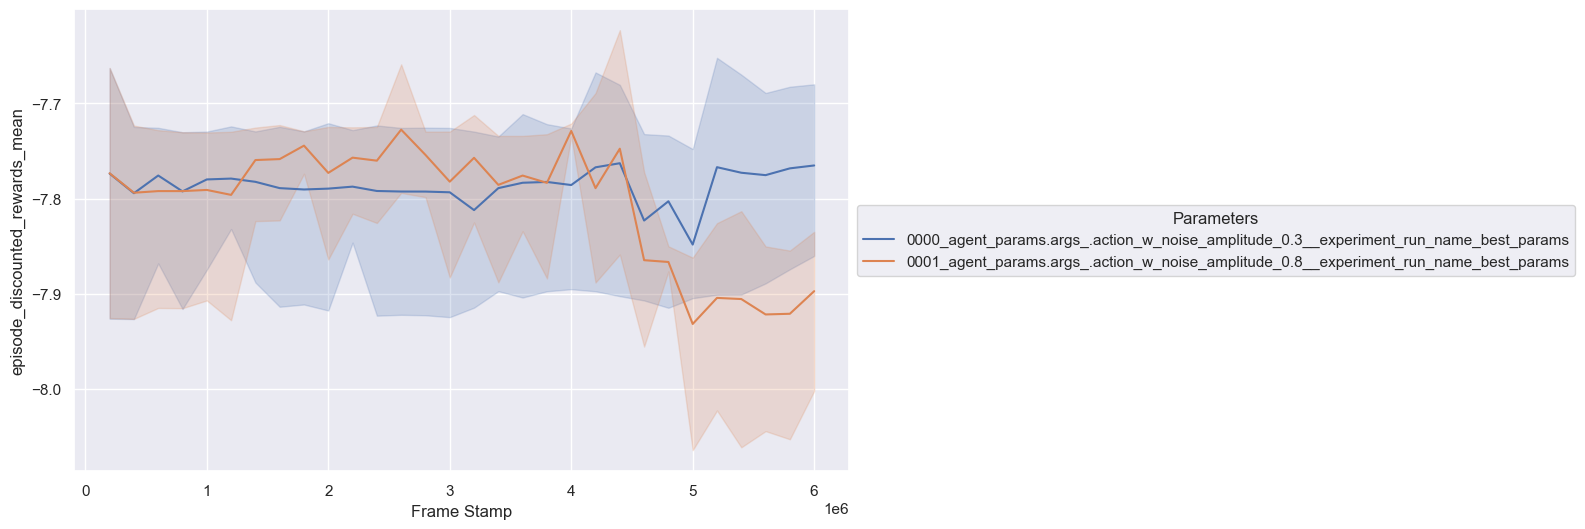

In [27]:

selected_metric = 'episode_discounted_rewards_mean'
# hue_col = "sub_exp_cfg_agent_params.args_.action_w_noise_amplitude"
hue_col = "experiment_name"

validation_df = df[df['epoch_type'] == 'validation']


# Create a new figure for each environment
plt.figure(figsize=(10, 6))
# sns.lineplot(data=df, x='frame_stamp', y=selected_metric, hue='model')
sns.lineplot(data=validation_df, x='frame_stamp', y=selected_metric, hue=hue_col)

plt.ylabel(selected_metric)
plt.xlabel('Frame Stamp')

# Place the legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), title='Parameters')
plt.show()

In [28]:
df.columns

Index(['epoch_type', 'frame_stamp', 'greedy_epsilon', 'episode_rewards_min',
       'episode_rewards_max', 'episode_rewards_mean', 'episode_rewards_median',
       'episode_rewards_std', 'episode_discounted_rewards_min',
       'episode_discounted_rewards_max', 'episode_discounted_rewards_mean',
       'episode_discounted_rewards_median', 'episode_discounted_rewards_std',
       'episode_frames_min', 'episode_frames_max', 'episode_frames_mean',
       'episode_frames_median', 'episode_frames_std', 'episode_losses_min',
       'episode_losses_max', 'episode_losses_mean', 'episode_losses_median',
       'episode_losses_std', 'episode_max_qs_min', 'episode_max_qs_max',
       'episode_max_qs_mean', 'episode_max_qs_median', 'episode_max_qs_std',
       'policy_trained_times', 'target_trained_times', 'epoch_time',
       'sub_exp_cfg_agent_params.args_.action_w_noise_amplitude',
       'sub_exp_cfg_experiment_run_name', 'sub_experiment_path', 'seed',
       'experiment_name'],
      dtype='

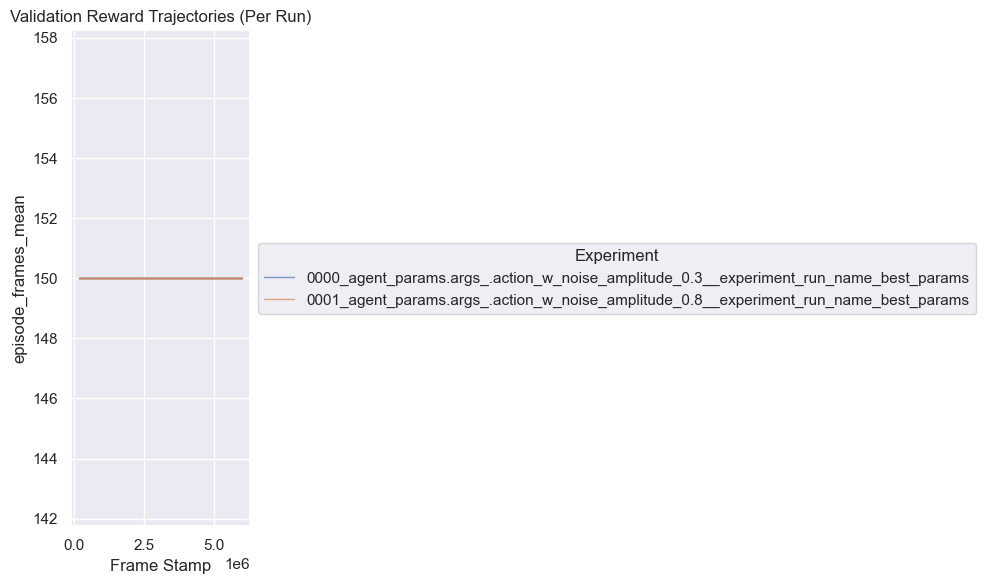

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

selected_metric = 'episode_frames_mean'
hue_col = "experiment_name"  # or another distinguishing column like "sub_experiment_path"

validation_df = df[df['epoch_type'] == 'validation']

# Plot individual lines for each run
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=validation_df,
    x='frame_stamp',
    y=selected_metric,
    hue=hue_col,
    estimator=None,  # ← disables aggregation
    units='sub_experiment_path',  # ← groups lines by unique run
    lw=1,  # line width
    alpha=0.7  # transparency
)

plt.ylabel(selected_metric)
plt.xlabel('Frame Stamp')
plt.title('Validation Reward Trajectories (Per Run)')

# Move legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), title='Experiment')
plt.tight_layout()
plt.show()


In [30]:
### Select data

experiment_columns = [
    'epoch_type', 'frame_stamp',
    'episode_rewards_mean', 'episode_frames_mean', 
    'episode_discounted_rewards_mean',
    'policy_trained_times', 'target_trained_times', 'epoch_time', 
       'seed', 'experiment_name', "sub_experiment_path"
]
hyperparam_columns = [
   col for col in df.columns if "sub_exp_cfg" in col
]

cols_of_interest = experiment_columns + hyperparam_columns

sub_df = df[cols_of_interest]
sub_df = sub_df[sub_df['epoch_type'] == 'validation']
sub_df = sub_df[sub_df['frame_stamp'] == sub_df['frame_stamp'].max()]

sub_df 


,epoch_type,frame_stamp,episode_rewards_mean,episode_frames_mean,episode_discounted_rewards_mean,policy_trained_times,target_trained_times,epoch_time,seed,experiment_name,sub_experiment_path,sub_exp_cfg_agent_params.args_.action_w_noise_amplitude,sub_exp_cfg_experiment_run_name
59,validation,6000000,-57.226076,150.0,-7.680134,NaN,NaN,0 days 00:00:00.554627,0,0000_agent_params.args_.action_w_noise_amplitu...,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0.3,best_params
119,validation,6000000,-59.343040,150.0,-7.860213,NaN,NaN,0 days 00:00:00.496603,1,0000_agent_params.args_.action_w_noise_amplitu...,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0.3,best_params
179,validation,6000000,-52.361504,150.0,-7.755543,NaN,NaN,0 days 00:00:00.448103,2,0000_agent_params.args_.action_w_noise_amplitu...,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0.3,best_params
239,validation,6000000,-59.787000,150.0,-7.854788,NaN,NaN,0 days 00:00:00.654085,0,0001_agent_params.args_.action_w_noise_amplitu...,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0.8,best_params
299,validation,6000000,-56.509390,150.0,-7.834920,NaN,NaN,0 days 00:00:00.535058,1,0001_agent_params.args_.action_w_noise_amplitu...,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0.8,best_params
359,validation,6000000,-59.714581,150.0,-8.001900,NaN,NaN,0 days 00:00:00.461043,2,0001_agent_params.args_.action_w_noise_amplitu...,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0.8,best_params


In [31]:
# agg_cols = [col for col in sub_df.columns if "sub_exp_cfg_agent_params" in col]
# aggregated_df = (
#     sub_df.groupby(agg_cols)
#     .agg(episode_discounted_rewards_mean=("episode_discounted_rewards_mean", "mean"))
#     .reset_index()
# )
# aggregated_df

In [32]:
sub_df.columns

Index(['epoch_type', 'frame_stamp', 'episode_rewards_mean',
       'episode_frames_mean', 'episode_discounted_rewards_mean',
       'policy_trained_times', 'target_trained_times', 'epoch_time', 'seed',
       'experiment_name', 'sub_experiment_path',
       'sub_exp_cfg_agent_params.args_.action_w_noise_amplitude',
       'sub_exp_cfg_experiment_run_name'],
      dtype='object')

In [33]:
# sub_df[[
#     "episode_discounted_rewards_mean", "episode_frames_mean",
#     "seed", "sub_exp_cfg_agent_params.args_.action_w_noise_amplitude"]
# ]

In [34]:
# sub_df[
#     (sub_df["sub_exp_cfg_agent_params.args_.action_w_noise_amplitude"] == "0.3") 
# ]

In [35]:
# Print the experiment_name of the row with the highest episode_rewards_mean 
print(sub_df[sub_df['episode_rewards_mean'] == sub_df['episode_rewards_mean'].max()]['sub_experiment_path'].values[0])
# print(sub_df[sub_df['episode_rewards_mean'] == sub_df['episode_rewards_mean'].max()]['experiment_name'].values[0])
# print(sub_df[sub_df['episode_rewards_mean'] == sub_df['episode_rewards_mean'].max()]['episode_rewards_mean'].values[0])


D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dynamics\experiments\results\2025May15-235344_configs\0000_agent_params.args_.action_w_noise_amplitude_0.3__experiment_run_name_best_params\2


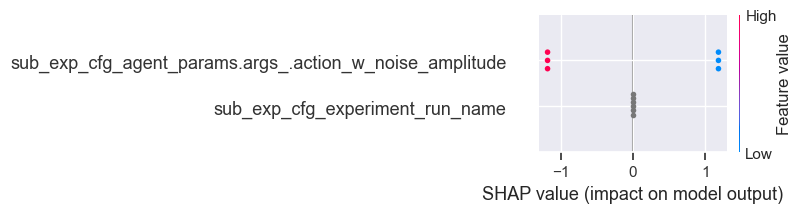

In [36]:
import shap
import xgboost
import pandas as pd


# Define the target metric and hyperparameter columns
target_metric = "episode_rewards_mean"  # Replace with actual metric column name
# Replace with actual hyperparameter column names

# Prepare data
X = sub_df[hyperparam_columns].apply(pd.to_numeric, errors='coerce')
y = sub_df[target_metric].fillna(3 * sub_df[target_metric].min())

# Train an XGBoost model to analyze feature importance
model = xgboost.XGBRegressor(objective="reg:squarederror", n_estimators=100, random_state=42)
model.fit(X, y)

# SHAP analysis
explainer = shap.Explainer(model)
shap_values = explainer(X)

# Summary plot (feature importance)
shap.summary_plot(shap_values, X)

In [37]:
hyperparam_columns

['sub_exp_cfg_agent_params.args_.action_w_noise_amplitude',
 'sub_exp_cfg_experiment_run_name']

In [38]:
import plotly.express as px

# Define readable names for selected hyperparams
readable_names = {
    hyperparam_columns[0]: "noise",
    hyperparam_columns[1]: "size"
}

# Rename columns in a copy of the dataframe
plot_df = sub_df.rename(columns=readable_names)

# Assign new column names
x_col = "noise"
y_col = "episode_rewards_mean"
facet_col = "size"

# Plot
fig = px.scatter(
    plot_df,
    x=x_col,
    y=y_col,
    color="experiment_name",  # Optional: color by experiment
    facet_col=facet_col,
    title="Episode Rewards vs. Noise Faceted by Size",
    height=600
)

fig.update_layout(showlegend=False)
fig.show()
